In [1]:
import os
import biom
import warnings
import numpy as np
import pandas as pd
import qiime2 as q2
from qiime2 import Artifact
from qiime2 import Metadata
from scipy.sparse.linalg import svds
from skbio import OrdinationResults
from scipy.sparse.linalg import svds
from skbio.stats.distance import permanova, anosim
from scipy.spatial.distance import cdist
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.actions import beta_group_significance
warnings.filterwarnings("ignore", category=DeprecationWarning)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# permanova

In [2]:
# set all simulations permanova
simulations_ = '../../data/data-driven-simulations'
sims = [dir_
        for dir_ in os.listdir(simulations_) 
        if dir_!='.DS_Store' and len(os.listdir(os.path.join(simulations_,dir_))) > 4]
perm_res = []
mfs = {}
for sim in sims:
    # simulation perams.
    depth_ = int(sim.split('-')[1])
    t_ = int(sim.split('-')[6])
    # import distances
    dists = {dist:Artifact.load(os.path.join(simulations_,sim,dist)).view(DistanceMatrix)
             for dist in os.listdir(os.path.join(simulations_,sim)) if 'distance' in dist}
    # import metadata
    meta = pd.read_csv(os.path.join(simulations_, sim, 'metadata.tsv'), sep='\t', index_col=0)
    # save metadata
    mfs[(depth_, t_)] = meta
    # run permanova
    perms = pd.concat({method_:pd.DataFrame(permanova(dist_, meta,
                                                      'diagnosis_full',
                                                      permutations=4000)) 
                       for method_, dist_ in dists.items()}).reset_index()
    perms.columns = ['method', 'type','PERMANOVA']
    perms['method'] = [v.split('-')[0] for v in perms['method']]
    perms['depth'] = depth_
    perms['timepoints'] = t_
    perm_res.append(perms)

perm_res = pd.concat(perm_res, axis=0)

renamed = {'aitchison':'Aitchison', 
           'braycurtis':'Bray-Curtis', 
           'distance':'CTF', 
           'state_distance_matrix.qza':'CTF',
           'jaccard':'Jaccard', 
           'unifrac':'UniFrac', 
           'wunifrac':'W-UniFrac',
           'w':'W-UniFrac'}
cmap_methods = {'Aitchison':'#377eb8', 
                'Bray-Curtis':'#ff7f00', 
                'CTF':'#4daf4a', 
                'ctf':'#b2df8a', 
                'Jaccard':'#999999', 
                'UniFrac':'#984ea3', 
                'W-UniFrac':'#e41a1c'}
perm_res = perm_res.replace(renamed)
perm_res = perm_res.reset_index(drop=True)
perm_res.to_csv('../../results/data-driven-benchmarking-PERMANOVA-simulations.tsv',sep='\t')
perm_res.head(5)


,method,type,PERMANOVA,depth,timepoints
0,UniFrac,method name,PERMANOVA,1000,4
1,UniFrac,test statistic name,pseudo-F,1000,4
2,UniFrac,sample size,83,1000,4
3,UniFrac,number of groups,2,1000,4
4,UniFrac,test statistic,4.22862,1000,4


In [5]:
fbymthd = {(depth_, method_):resdf_[(resdf_.type.isin(['test statistic'])) & (resdf_.timepoints > 1)].set_index('timepoints') 
           for (depth_, method_), resdf_ in perm_res.groupby(['depth','method'])}

permres_finc = pd.DataFrame({k:["%.2f ± %.2f"%(np.mean(fbymthd[(k[0], 'CTF')].loc[df.index, :].PERMANOVA.values/df.PERMANOVA.values),
                                 np.std(fbymthd[(k[0], 'CTF')].loc[df.index, :].PERMANOVA.values/df.PERMANOVA.values))]
              for k,df in fbymthd.items()},['Fold-Change']).T.sort_index()
permres_finc.to_csv('../../results/data-driven-benchmarking-permanova-improvement-simulations.tsv',sep='\t')
permres_finc


Fold-Change
500   Aitchison    3.90 ± 1.93
      Bray-Curtis  4.78 ± 2.42
      CTF          1.00 ± 0.00
      Jaccard      4.69 ± 2.36
      UniFrac      3.01 ± 1.48
      W-UniFrac    5.55 ± 3.08
1000  Aitchison    3.20 ± 1.28
      Bray-Curtis  4.23 ± 1.80
      CTF          1.00 ± 0.00
      Jaccard      3.66 ± 1.61
      UniFrac      2.23 ± 0.85
      W-UniFrac    5.69 ± 2.12
10000 Aitchison    3.67 ± 1.94
      Bray-Curtis  6.80 ± 4.11
      CTF          1.00 ± 0.00
      Jaccard      3.54 ± 1.97
      UniFrac      1.91 ± 1.02
      W-UniFrac    9.94 ± 6.33

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


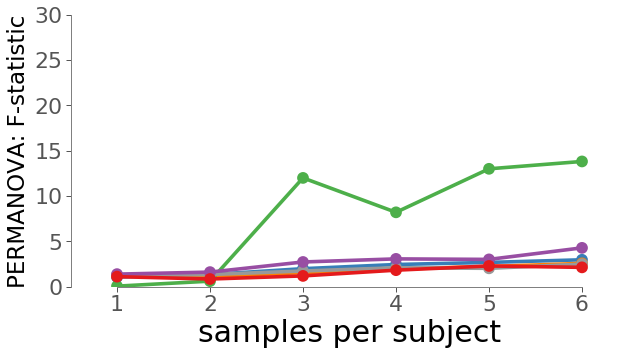

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


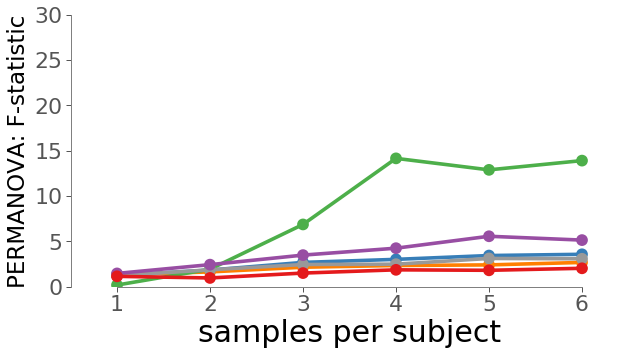

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


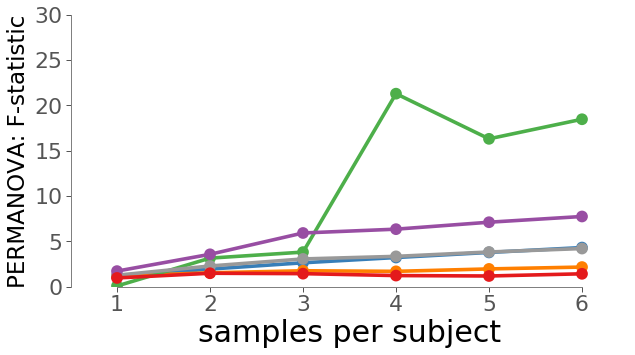

In [25]:
for t_, tdf_ in perm_res.groupby('depth'):
    tdf_plot = tdf_[tdf_.type.isin(['test statistic'])]
    tdf_plot.loc[:, 'PERMANOVA'] = tdf_plot.loc[:, 'PERMANOVA'].astype(float)
    #tdf_plot = tdf_plot[tdf_plot.timepoints < 7]
    # set label font-sizes globally
    paper_rc = {'lines.linewidth': 2, 
                'lines.markersize': 10}                  
    sns.set_context("paper", rc = paper_rc)   
    plt.rcParams['xtick.labelsize'] = 22 
    plt.rcParams['ytick.labelsize'] = 22

    fig, ax = plt.subplots(1,1, figsize=(10,5))

    sns.pointplot(x='timepoints', y='PERMANOVA', hue='method',
                  data=tdf_plot.sort_values('method'),
                  ax=ax, palette=cmap_methods, ci=0)

    ax.set_ylabel('PERMANOVA: F-statistic', fontsize=23, color='black')
    ax.set_xlabel('samples per subject', fontsize=30, color='black')
    #ax.axhline(.5, lw=2, ls='--', c='#e41a1c')
    ax.set_ylim(0.0,30)
    #ax.set_yscale('symlog', linthreshy=10)


    # generate legend from last iterations     
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1], loc=2, 
                             bbox_to_anchor=(1.0, 1.0),
                             prop={'size':25},
                             fancybox=True, framealpha=0.5, 
                             ncol=1, markerscale=2, facecolor="white")
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(8.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(4.0)

    # remove all grids, backrounds etc ...
    ax.legend_.remove()
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(0, 5)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    # set the backrounf to be transparent
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.0)

    # save the figure to file
    plt.savefig('../../results/data-driven-benchmarking-bench-PERMANOVA-%i.pdf'%(t_),dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

    plt.show()

# KNN-classification

In [30]:
from inspect import signature
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

cmap_methods = {'Aitchison':'#377eb8', 
                'Bray-Curtis':'#ff7f00', 
                'CTF':'#4daf4a', 
                'Jaccard':'#999999', 
                'UniFrac':'#984ea3', 
                'W-UniFrac':'#e41a1c'}

In [35]:
# get map
mf = pd.read_csv('../../data/Halfvarson-IBD-Qiita-1629/metadata-matched.tsv',
                 sep='\t', index_col=0)
ibd_map = pd.DataFrame({k:[v] for k,v in zip(mf.host_subject_id,mf.IBD)},['IBD']).T

# for each sim   
ord_depth_ntime = {500:{},
                   1000:{},
                   10000:{}}
for sim in sims:
    depth_ = int(sim.split('-')[1])
    t_ = int(sim.split('-')[6])
    
    # import pcoa data
    ords = {dist:pd.concat([Artifact.load(os.path.join(simulations_,sim,dist)).view(OrdinationResults).samples,
                            mfs[(depth_, t_)]],
                            axis=1,
                            sort=True).groupby('host_subject_id').sum()
             for dist in os.listdir(os.path.join(simulations_,sim)) if 'pcoa' in dist}
    ords = {k:ord_.loc[:, set(list(range(200))) & set(ord_.columns)] 
            for k,ord_ in ords.items()}
    biplots = {dist:Artifact.load(os.path.join(simulations_,sim,dist)).view(OrdinationResults).samples[[0,1]]
               for dist in os.listdir(os.path.join(simulations_,sim)) if 'subject-biplot' in dist}
    ords = {**ords,**biplots}
    
    ord_depth_ntime[depth_][t_] = ords

    

In [37]:
res = {}
majority_res = {}
for depth_, ord_ntime in ord_depth_ntime.items():
    for t_, ords_ in ord_ntime.items():
        for method, ord_ in ords_.items():

            X = ord_.values
            sids = ord_.index
            y = ibd_map.loc[sids, 'IBD']

            le = preprocessing.LabelEncoder()
            le.fit(y)
            y = le.transform(y) 

            scoring_ = {'APR':'average_precision',
                        'AUC':'roc_auc'}

            for scoring_method, scoring_ in scoring_.items():

                # instantiate the grid
                k_range = list(range(8, 15))
                param_grid = dict(n_neighbors=k_range)
                param_grid['p'] = [1, 2]
                classifier = KNeighborsClassifier()
                grid = GridSearchCV(classifier, param_grid, cv=8,
                                    scoring=scoring_)
                grid.fit(X, y)
                classifier = grid.best_estimator_
                
                majority_res[(depth_, t_, method.split('-')[0], 'truth')] = y
                majority_res[(depth_, t_, method.split('-')[0], 'ids')] = sids
                majority_res[(depth_, t_, method.split('-')[0], 'probability')] = grid.predict_proba(X)
                majority_res[(depth_, t_, method.split('-')[0], 'prediction')] = grid.predict(X)

                for i, score_ in enumerate(grid.cv_results_['mean_test_score']):
                    res[(depth_, t_, method.split('-')[0], scoring_method, i)] = [score_]

knnres = pd.DataFrame(res).T.reset_index()
knnres.columns = ['Depth','timepoints',
                  'Method','Scoring-Method',
                  'Fold','Score']
knnres = knnres.replace(renamed)
knnres['Method'] = knnres['Method'].replace({'subject':'CTF'})
knnres.to_csv('../../results/data-driven-benchmarking-knn-simulations.tsv',sep='\t')
knnres.head(5)

,Depth,timepoints,Method,Scoring-Method,Fold,Score
0,500,3,W-UniFrac,APR,0,0.757246
1,500,3,W-UniFrac,APR,1,0.804348
2,500,3,W-UniFrac,APR,2,0.833333
3,500,3,W-UniFrac,APR,3,0.793478
4,500,3,W-UniFrac,APR,4,0.815217


In [38]:
for metric_ in ['AUC', 'APR']:
    knnres_tst = knnres[knnres['timepoints'] > 1][knnres['Scoring-Method'].isin([metric_])]
    fbymthd = {(smethod_, method_):resdf_.groupby('timepoints').mean()
               for (smethod_, method_), resdf_ in knnres_tst.groupby(['Depth','Method'])}

    knnres_pinc = pd.DataFrame({k:["%.2f ± %.2f"%(np.mean(fbymthd[(k[0], 'CTF')].loc[df.index, :].Score.values - df.Score.values)*100,
                                     np.std(fbymthd[(k[0], 'CTF')].loc[df.index, :].Score.values - df.Score.values)*100)]
                  for k,df in fbymthd.items()},['percent-increase']).T.sort_index()
    knnres_pinc.to_csv('../../results/data-driven-benchmarking-knn-improvement-simulations-%s.tsv' % (metric_),sep='\t')
    print(knnres_pinc)



                  percent-increase
500   Aitchison      37.14 ± 10.28
      Bray-Curtis     37.47 ± 8.14
      CTF              0.00 ± 0.00
      Jaccard         30.14 ± 6.08
      UniFrac         25.87 ± 9.14
      W-UniFrac      34.49 ± 10.55
1000  Aitchison       31.32 ± 5.93
      Bray-Curtis     32.08 ± 3.75
      CTF              0.00 ± 0.00
      Jaccard         28.76 ± 3.91
      UniFrac         24.47 ± 6.87
      W-UniFrac       41.29 ± 6.00
10000 Aitchison       33.85 ± 4.16
      Bray-Curtis     34.39 ± 9.43
      CTF              0.00 ± 0.00
      Jaccard         25.12 ± 6.42
      UniFrac         19.52 ± 3.83
      W-UniFrac      39.55 ± 10.94
                  percent-increase
500   Aitchison       21.09 ± 6.08
      Bray-Curtis     21.04 ± 4.67
      CTF              0.00 ± 0.00
      Jaccard         16.98 ± 4.05
      UniFrac         14.83 ± 5.34
      W-UniFrac       19.95 ± 6.59
1000  Aitchison       19.16 ± 3.32
      Bray-Curtis     19.87 ± 2.78
      CTF           

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [39]:
from sklearn import metrics

majority_score = {}
for depth_ in ord_depth_ntime.keys():
    for method in ords_.keys():
        # 'prediction'
        majpred_ = []
        majtruth_ = []
        for t_ in sorted(ord_ntime.keys()):
            df_t = pd.DataFrame(majority_res[(depth_, t_, method.split('-')[0], 'prediction')],
                     majority_res[(depth_, t_, method.split('-')[0], 'ids')])
            dft_t = pd.DataFrame(majority_res[(depth_, t_, method.split('-')[0], 'truth')],
                     majority_res[(depth_, t_, method.split('-')[0], 'ids')])
            majpred_.append(df_t)
            majtruth_.append(dft_t)

        majdf = pd.concat([pd.concat(majpred_, axis=1, sort='False').mode(axis=1).min(axis=1),
                           pd.concat(majtruth_, axis=1, sort='False').mode(axis=1).min(axis=1)],axis=1,
                          sort='False')
        majdf.columns = ['predicted','truth']
        majority_score[(depth_, method.split('-')[0])] = [metrics.roc_auc_score(majdf['truth'].values,
                                                                 majdf['predicted'].values),
                                            metrics.average_precision_score(majdf['truth'].values,
                                                                 majdf['predicted'].values)]

majority_score = pd.DataFrame(majority_score).T
majority_score = 1 - majority_score
majority_score = majority_score.reset_index()
majority_score = majority_score.replace({**renamed,**{'subject':'CTF'}})
majority_score.columns = ['Depth','Method','AUC Error','AP Error']



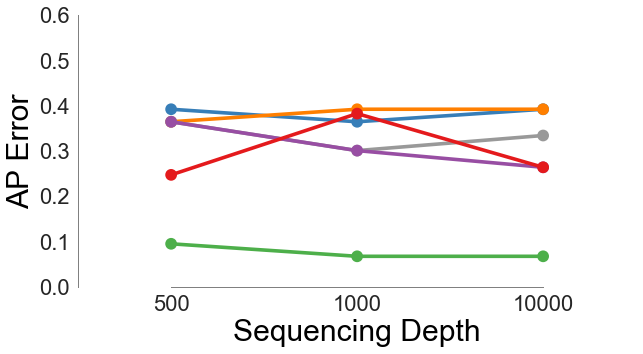

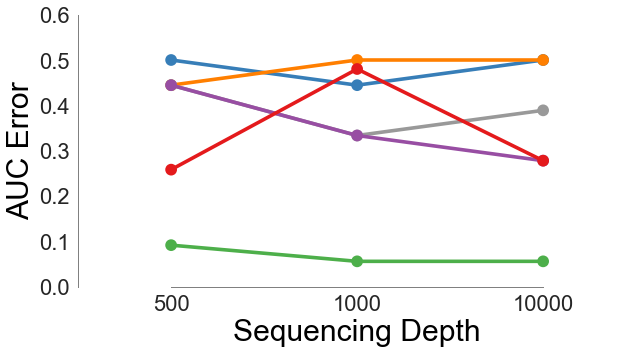

In [41]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 22 
plt.rcParams['ytick.labelsize'] = 22

for y_, df_plot in zip(['AP Error', 'AUC Error'],
                       [majority_score, majority_score]):

        fig, ax = plt.subplots(1,1, figsize=(10,5))
                
        sns.pointplot(x='Depth', y=y_, hue='Method',
                      data=df_plot.sort_values('Method'),
                      ax=ax, palette=cmap_methods)
        ax.set_ylabel(y_,
                      fontsize=30, color='black')
        ax.set_xlabel('Sequencing Depth', fontsize=30, color='black')
        #if y_score == 'AUC':
        #    ax.set_ylim(0.0,.8)
        #else:
        ax.set_ylim(0.0,.6)

        # generate legend from last iterations     
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[::-1], labels[::-1], loc=2, 
                                 bbox_to_anchor=(1.0, 1.0),
                                 prop={'size':25},
                                 fancybox=True, framealpha=0.5, 
                                 ncol=1, markerscale=2, facecolor="white")
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(8.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(4.0)

        # remove all grids, backrounds etc ...
        ax.legend_.remove()
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_bounds(0, 2)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

        # set the backrounf to be transparent
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.0)
        # save the figure to file
        plt.savefig('../../results/majority-votes-KNN-%s.pdf'%(y_.replace(' ','-')),dpi=1000, 
                   bbox_inches='tight',
                    facecolor=fig.get_facecolor(), 
                    edgecolor='none')

        plt.show()

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


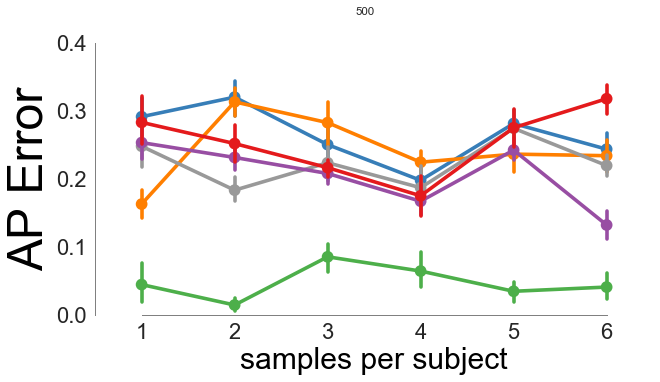

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


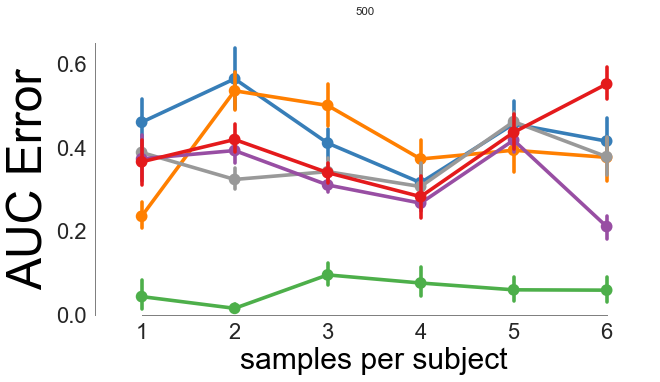

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


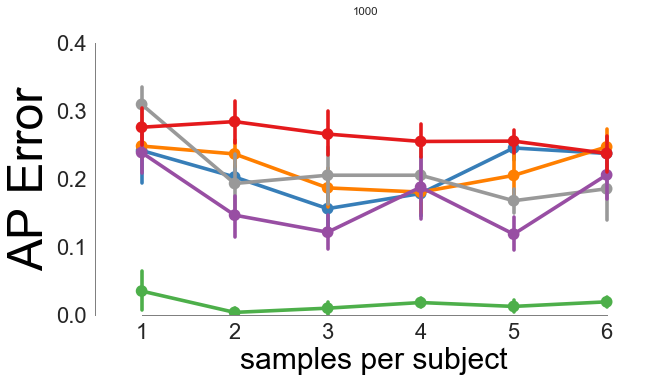

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


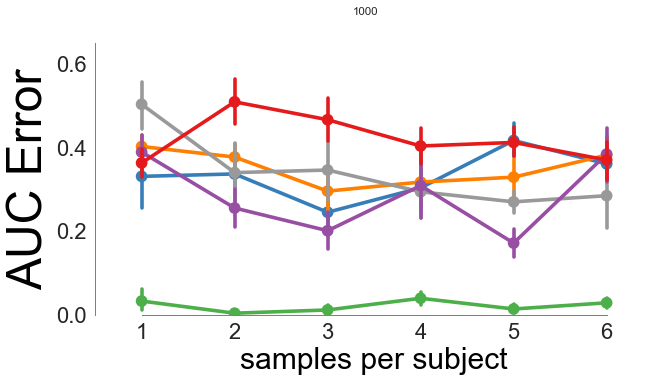

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


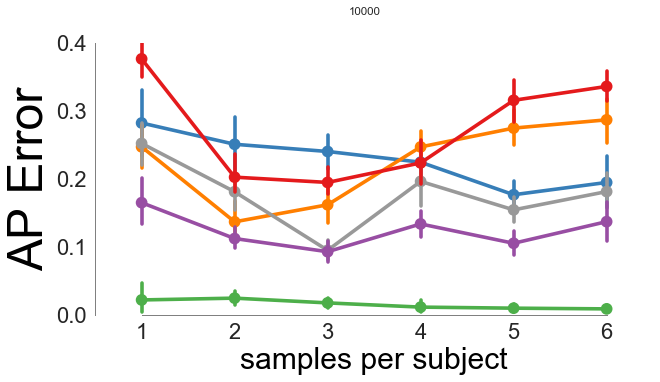

/Users/cmartino/miniconda3/envs/qiime2-2019.10-tut/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


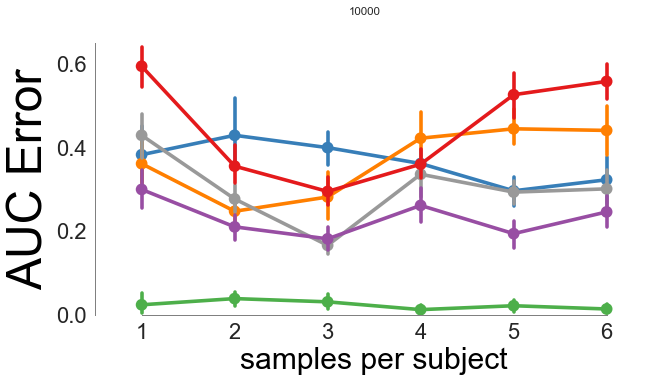

In [48]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 22 
plt.rcParams['ytick.labelsize'] = 22

for depth_, ddf_plot in knnres.groupby('Depth'):
    ddf_plot = ddf_plot[ddf_plot.timepoints < 7]

    for y_score, df_plot in ddf_plot.groupby('Scoring-Method'):

        fig, ax = plt.subplots(1,1, figsize=(10,5))
        df_plot['log_error'] = (1.00 - df_plot['Score'])
        
        df_plot = df_plot.replace({'APR':'AP'})
        
        sns.pointplot(x='timepoints', y='log_error', hue='Method',
                      data=df_plot.sort_values('Method'),
                      ax=ax, palette=cmap_methods)
        ax.set_ylabel('%s Error'%y_score.replace('APR','AP'),
                      fontsize=48, color='black')
        ax.set_xlabel('samples per subject', fontsize=30, color='black')
        if y_score == 'AUC':
            ax.set_ylim(0.0,.65)
        else:
            ax.set_ylim(0.0,.4)

        # generate legend from last iterations     
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[::-1], labels[::-1], loc=2, 
                                 bbox_to_anchor=(1.0, 1.0),
                                 prop={'size':25},
                                 fancybox=True, framealpha=0.5, 
                                 ncol=1, markerscale=2, facecolor="white")
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(8.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(4.0)

        # remove all grids, backrounds etc ...
        ax.legend_.remove()
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_bounds(0, 5)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

        # set the backrounf to be transparent
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.0)
        # save the figure to file
        plt.savefig('../../results/bench-KNN-%i-%s.pdf'%(depth_,y_score),dpi=1000, 
                    bbox_inches='tight',
                    facecolor=fig.get_facecolor(), 
                    edgecolor='none')
        plt.suptitle(depth_)

        plt.show()
